Written by Jonas Chan Leong Sean for the Udacity Self Driverless Car Course for the
project:
ADVANCED LANE LINES

The final video has been uploaded here:
https://www.youtube.com/watch?v=161gDwYKtqQ

__Import all required libraries

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
%matplotlib inline

__Obtain Camera Calibration Parameters

In [2]:
debug = True
calibration_images_path = 'calibration_wide/GO*.jpg'
calibration_test_image_path = 'calibration_wide/GOPR0032.jpg'
road_with_lanes_path = 'test_images/test3.jpg'
path = "signs_vehicles_xygrad.png"

In [3]:
def convert_BGR_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convert_BGR_to_GRAY(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
def import_calibration_images(path):
    images = glob.glob(path)
    return images

In [5]:
def obtain_calibration_parameters(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list of calibration images and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    if debug == True:
        print("The number of images passed in is: " + str(len(images)))
        print("The number of objpoints obtained is: " + str(len(objpoints)))
        print("The number of imgpoints obtained is: " + str(len(imgpoints)))
        
    return objpoints, imgpoints

In [6]:
def calibrate_img(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)   
    return mtx, dist

In [7]:
def undistort_img(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [8]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = undistort_img(img, mtx, dist)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped

In [9]:
def start_camera_calibration():    
    calibration_parameters = obtain_calibration_parameters(import_calibration_images(calibration_images_path))
    test_image = cv2.imread(calibration_test_image_path)

    mtx, dist = calibrate_img(test_image, calibration_parameters[0], calibration_parameters[1])
    warped = corners_unwarp(test_image, 8, 6, mtx, dist)

    if debug == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.set_title('Test Image', fontsize=30)
        ax1.imshow(convert_BGR_to_RGB(test_image))
        ax2.set_title('Calibrated Image', fontsize=30)
        ax2.imshow(convert_BGR_to_RGB(warped))

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return calibration_parameters

__Undistorting a test image

In [10]:
clean_img = None
def undistort_road_image(img, calibration_parameters):    
    road_image_calibration_parameters = calibrate_img(img, 
                                                      calibration_parameters[0], 
                                                      calibration_parameters[1])
    
    undistorted_road = undistort_img(img, 
                                     road_image_calibration_parameters[0], 
                                     road_image_calibration_parameters[1])
    
    global clean_img
    clean_img = undistorted_road
    
    if debug == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.set_title('Distorted Test Image', fontsize=30)
        ax1.imshow(convert_BGR_to_RGB(img))
        ax2.set_title('Undistorted Test Image', fontsize=30)
        ax2.imshow(convert_BGR_to_RGB(undistorted_road))
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return undistorted_road

__Perspective Transform

In [11]:
Minv = None

def warp(img):
    imgg_size = (img.shape[1], img.shape[0])
    
    img_size = img.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    
    ctl_window = c_window - .25 * np.uint(img_size[1] / 2)
    ctr_window = c_window + .25 * np.uint(img_size[1] / 2)
    cbl_window = c_window - 1 * np.uint(img_size[1] / 2)
    cbr_window = c_window + 1 * np.uint(img_size[1]/2)
    
    src = np.float32([[cbl_window, hb_window],
                      [cbr_window, hb_window],
                      [ctr_window, ht_window],
                      [ctl_window, ht_window]])
        
    dst = np.float32([[0,img_size[0]],
                      [img_size[1],img_size[0]],
                      [img_size[1],0],
                      [0,0]])
    
    #Get the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    global Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Create warped image using linear interpolation
    warped = cv2.warpPerspective(img, M, imgg_size, flags=cv2.INTER_LINEAR)
    
    if (debug == True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(convert_BGR_to_RGB(img))
        ax1.scatter(0, 720, s = 120, c = 'r')
        ax1.scatter(1280, 720, s = 120, c = 'g')
        ax1.scatter(800, 480, s = 120, c = 'b')
        ax1.scatter(480, 480, s = 120, c = 'y')       
        ax1.set_title('Original Image', fontsize=30)
        
        ax2.imshow(convert_BGR_to_RGB(warped))
        ax2.scatter(0, 720, s = 120, c = 'r')
        ax2.scatter(1280, 720, s = 120, c = 'g')
        ax2.scatter(1280, 0, s = 120, c = 'b')
        ax2.scatter(0, 0, s = 120, c = 'y')
        ax2.set_title('Warped', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax3.imshow(convert_BGR_to_RGB(img))
        ax3.set_title('Original Image', fontsize=30)
        ax4.imshow(convert_BGR_to_RGB(warped))
        ax4.set_title('Warped', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped

__Applying Thresholding

In [12]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

def combined(img, color=False, mag_dir_thresh=False):
   
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    plt.imshow(white_mask)
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)
    
    masked_binary = np.zeros_like(white_mask)
    masked_binary[((white_mask == 255) | (yellow_mask == 255))] = 255

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=15)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=15)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    scaled_sobel = (gradmag/scale_factor).astype(np.uint8) 
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[(combined_binary == 255) | (masked_binary == 255)] = 1
    return combined_binary

In [13]:
warped = None
def thresholding_type_select(thresholding_type, img, thresholding_min, thresholding_max, kernel_size = 5):
    
    if(thresholding_type == "sobel_x"):
        thresholded_image = abs_sobel_thresh(img,
                                             orient='x',
                                             thresh_min = thresholding_min,
                                             thresh_max = thresholding_max)
    
    elif(thresholding_type == "sobel_y"):
        thresholded_image = abs_sobel_thresh(img,
                                             orient='y',
                                             thresh_min = thresholding_min,
                                             thresh_max = thresholding_max)
    
    elif(thresholding_type == "sobel_magnitude"):
        thresholded_image = mag_thresh(img, 
                                       sobel_kernel = kernel_size,
                                       mag_thresh = (thresholding_min, thresholding_max))
        
    elif(thresholding_type == "sobel_directional"):
        thresholded_image = dir_threshold(img,
                                          sobel_kernel = kernel_size,
                                          thresh = (thresholding_min, thresholding_max))
    
    elif(thresholding_type == "hls_colorspace"):
        thresholded_image = hls_select(img, 
                                       thresh = (thresholding_min, thresholding_max))
        
    elif(thresholding_type == "combined"):
        thresholded_image = combined(img)
    
    #Preview the thresholded image
    if (debug == True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(convert_BGR_to_RGB(img))
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(thresholded_image, cmap='gray')
        cv2.imwrite("BinaryImage.jpg", thresholded_image)
        ax2.set_title(thresholding_type, fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    global warped
    warped = thresholded_image    
    return thresholded_image

__Lane Detection

In [14]:
mse_tolerance = 0.01
left_fit_init = [np.array([False])] 
right_fit_init = [np.array([False])] 
     
def update_fits(left_fit_test, right_fit_test):
    global left_fit_init
    global right_fit_init
    
    if first_frame_processed:
        left_error = ((left_fit_init[0] - left_fit_test[0]) ** 2).mean(axis=None)      
        right_error = ((right_fit_init[0] - right_fit_test[0]) ** 2).mean(axis=None)        
        if left_error < mse_tolerance:
            left_fit_init = 0.75 * left_fit_init + 0.25 * left_fit_test   
        if right_error < mse_tolerance:
            right_fit_init = 0.75 * right_fit_init + 0.25 * right_fit_test
    else:
        right_fit_init = right_fit_test
        left_fit_init = left_fit_test

In [15]:
def calculate_curvature(thresholded_image, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/719.0 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    thresholded_img_shape = thresholded_image.shape[0]
    ploty = np.linspace(0, thresholded_img_shape - 1, thresholded_img_shape)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = thresholded_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        
        # Fit new polynomials to x, y in world space
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters

    return left_curverad, right_curverad

In [16]:
left_curvature = 0
right_curvature = 0
first_frame_processed = False  

def start_lane_detection(img):
    margin = 100
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    global first_frame_processed
    global left_curvature
    global right_curvature

    if not first_frame_processed:
        histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base
        
        nwindows = 9

        # Height of windows
        window_height = np.int(img.shape[0]/nwindows)        

        # Minimum number of pixels found to recenter window
        minpix = 50
    
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        current_fit = update_fits(left_fit, right_fit)
        
        left_curvature, right_curvature = calculate_curvature(img, left_lane_inds, right_lane_inds)

        first_frame_processed = True
     
    else:
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = left_fit_init
        right_fit = right_fit_init
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - 100)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + 100))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - 100)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + 100)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        update_fits(np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2))
        left_fit = left_fit_init
        right_fit = right_fit_init
        left_curvature, right_curvature = calculate_curvature(img, left_lane_inds, right_lane_inds)

    ## Visualization
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(clean_img, 1, newwarp, 0.3, 0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(convert_BGR_to_RGB(clean_img))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(convert_BGR_to_RGB(result))
    ax2.set_title('Final Output', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    cv2.putText(result,'Made By: Jonas Chan',(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    cv2.putText(result,'Left Curvature: %.2fm' % left_curvature,(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    cv2.putText(result,'Right Curvature: %.2fm' % right_curvature,(20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    print("The left curvature in meters is: " + str(left_curvature))
    print("The right curvature in meters is: " + str(right_curvature))

    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/719.0
    y_eval = 719.0
    midx = 650

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    
    print("The position from center is: " + str(position_from_center))

    if position_from_center < 0:
        text = 'to the left'
    else:
        text = 'to the right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,160), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result

In [17]:
camera_calibration_parameters = None

def get_cam_cal_data():
    global camera_calibration_parameters
    camera_calibration_parameters = start_camera_calibration()

In [18]:
def begin_lane_detection(raw_image):
    undistorted_image = undistort_road_image(raw_image, camera_calibration_parameters)
    warped_image = warp(undistorted_image)
    threshed = thresholding_type_select("combined",
                                                 warped_image,
                                                 30, 100, 15)
    final_image = start_lane_detection(threshed)

    return final_image

In [19]:
def lane_detection_pipeline(raw_image):
    if(camera_calibration_parameters != None):
        processed_image = begin_lane_detection(raw_image)
    
    else:
        print("camera_calibration_parameters was previously empty, running camera calibration now...")
        get_cam_cal_data()
        print("Camera calibration complete! Starting lane detection now...")        
        processed_image = begin_lane_detection(raw_image)
        
    return processed_image

camera_calibration_parameters was previously empty, running camera calibration now...
The number of images passed in is: 36
The number of objpoints obtained is: 35
The number of imgpoints obtained is: 35
Camera calibration complete! Starting lane detection now...


/Users/holovisinternational/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The left curvature in meters is: 772.205073182
The right curvature in meters is: 3045.16091134
The position from center is: 0.31492779997


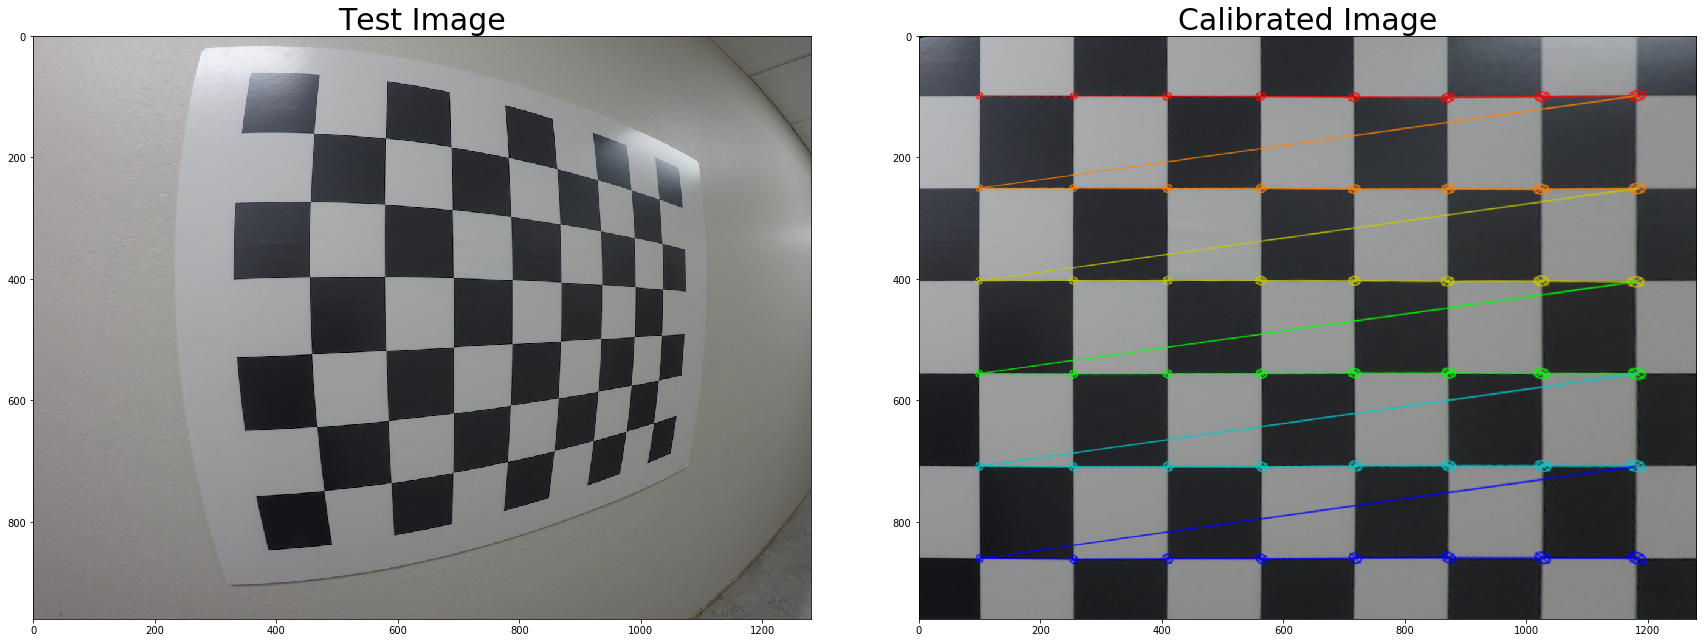

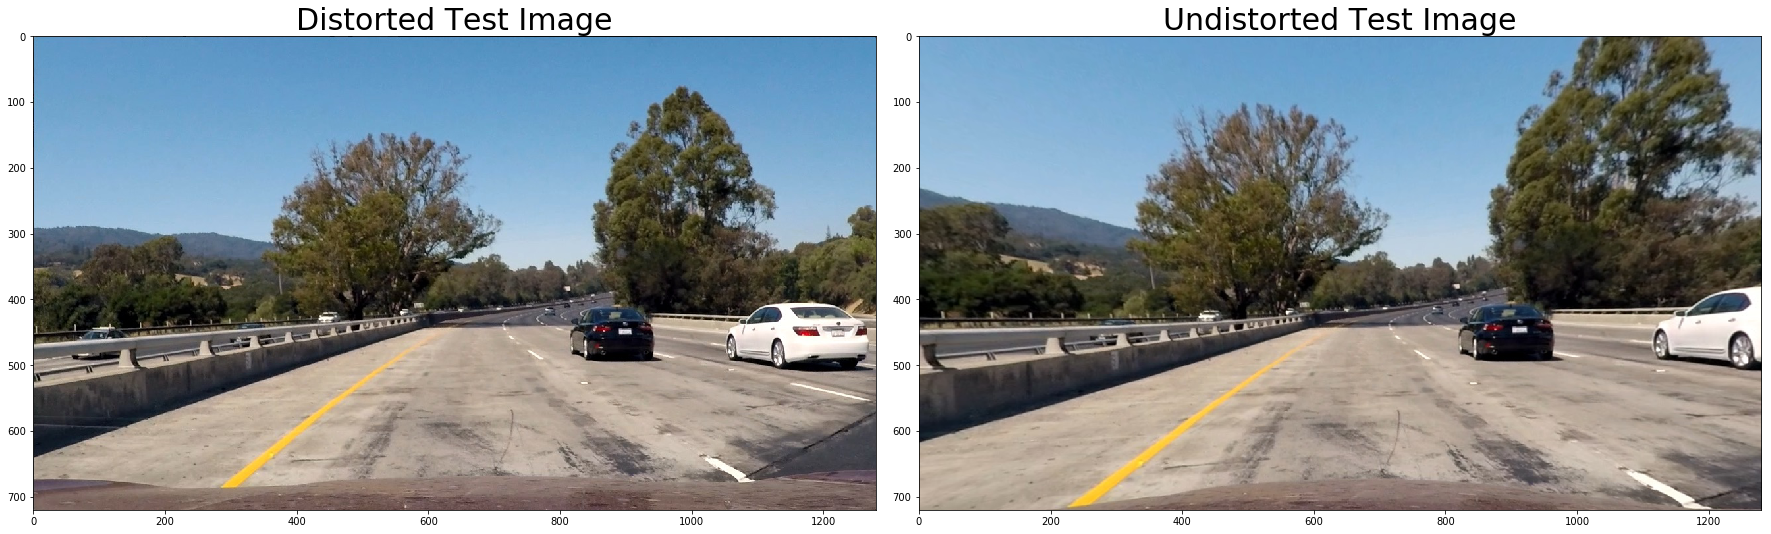

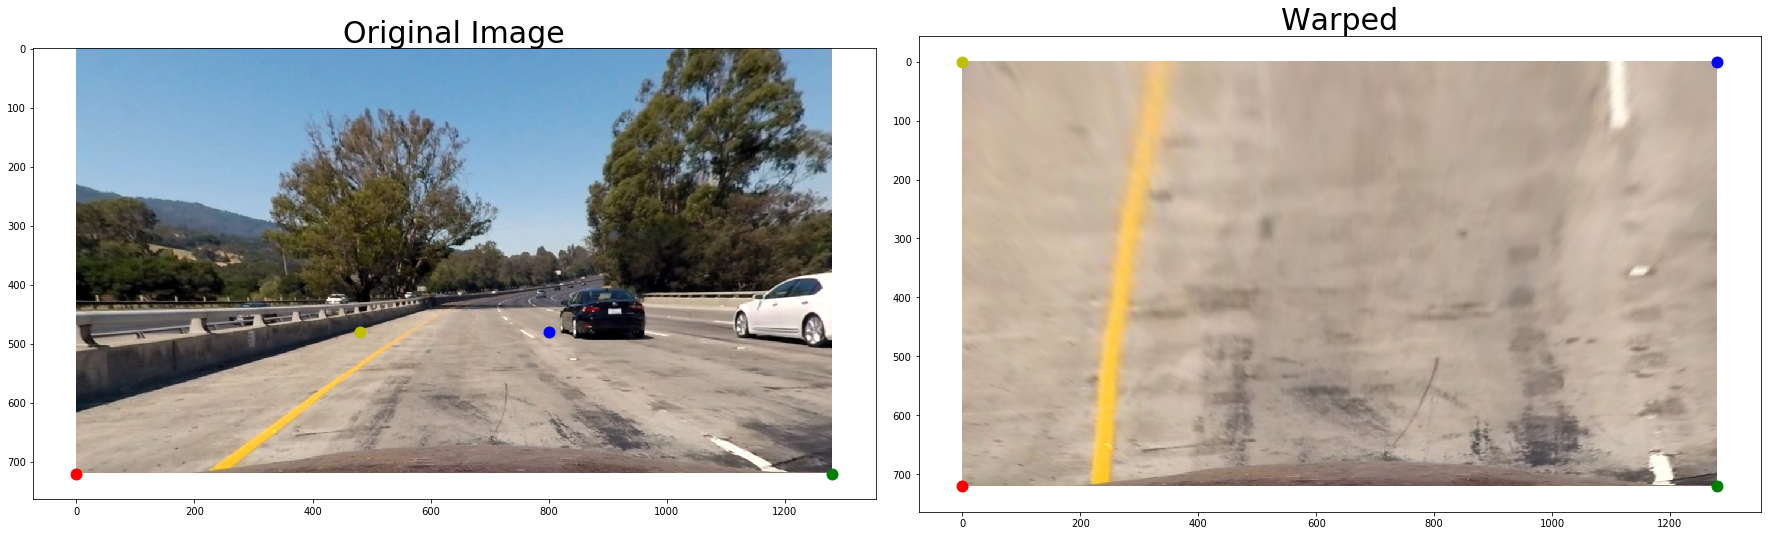

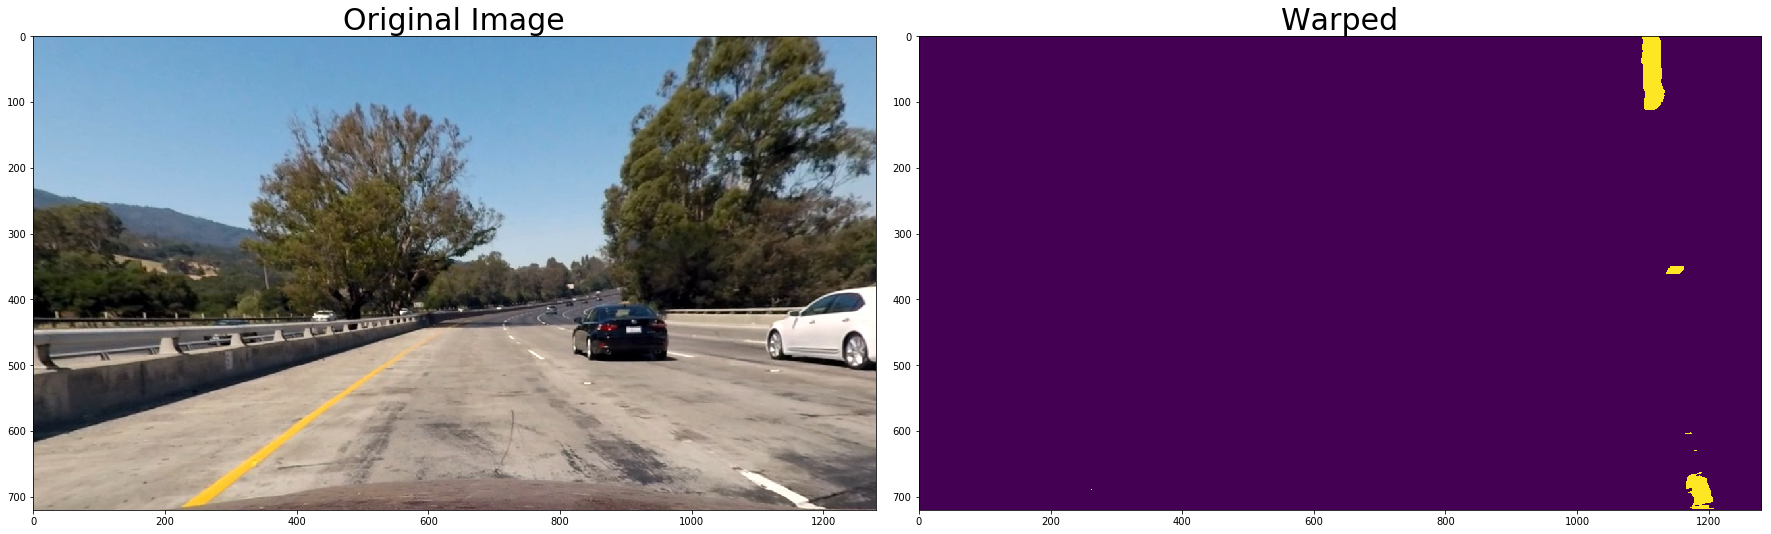

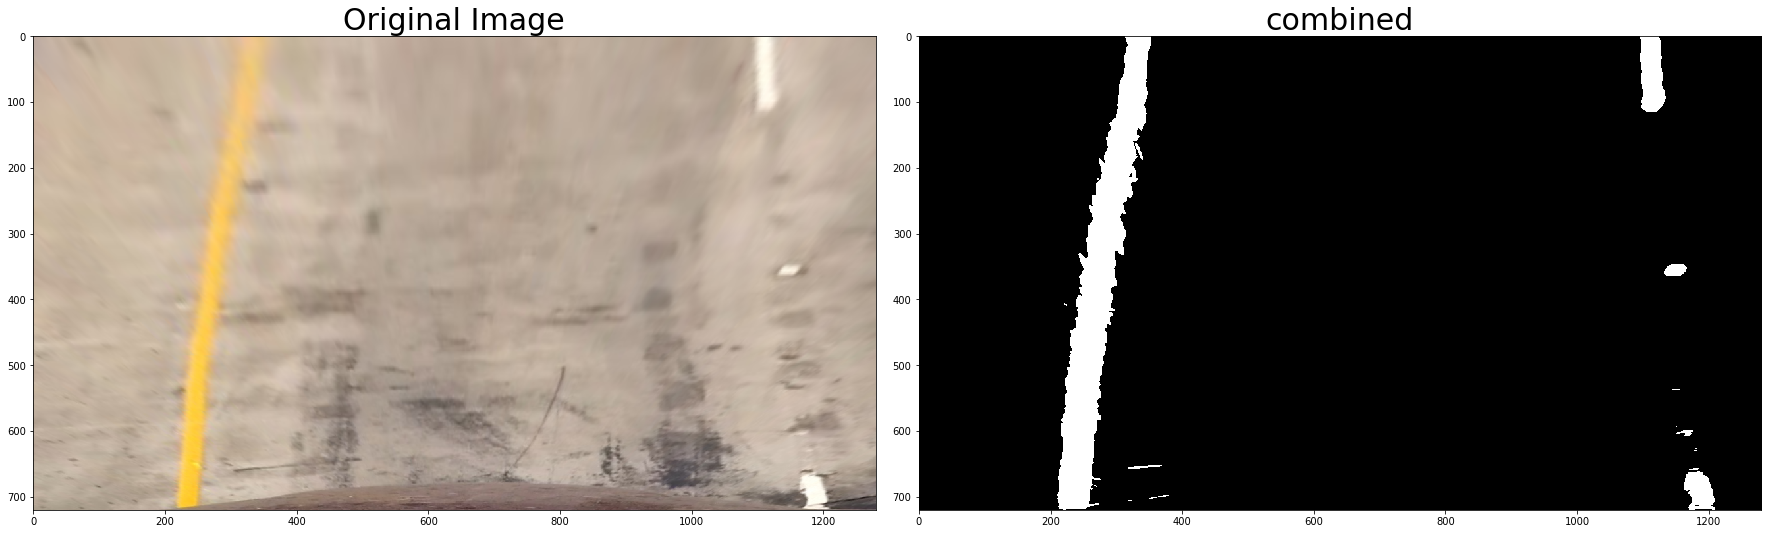

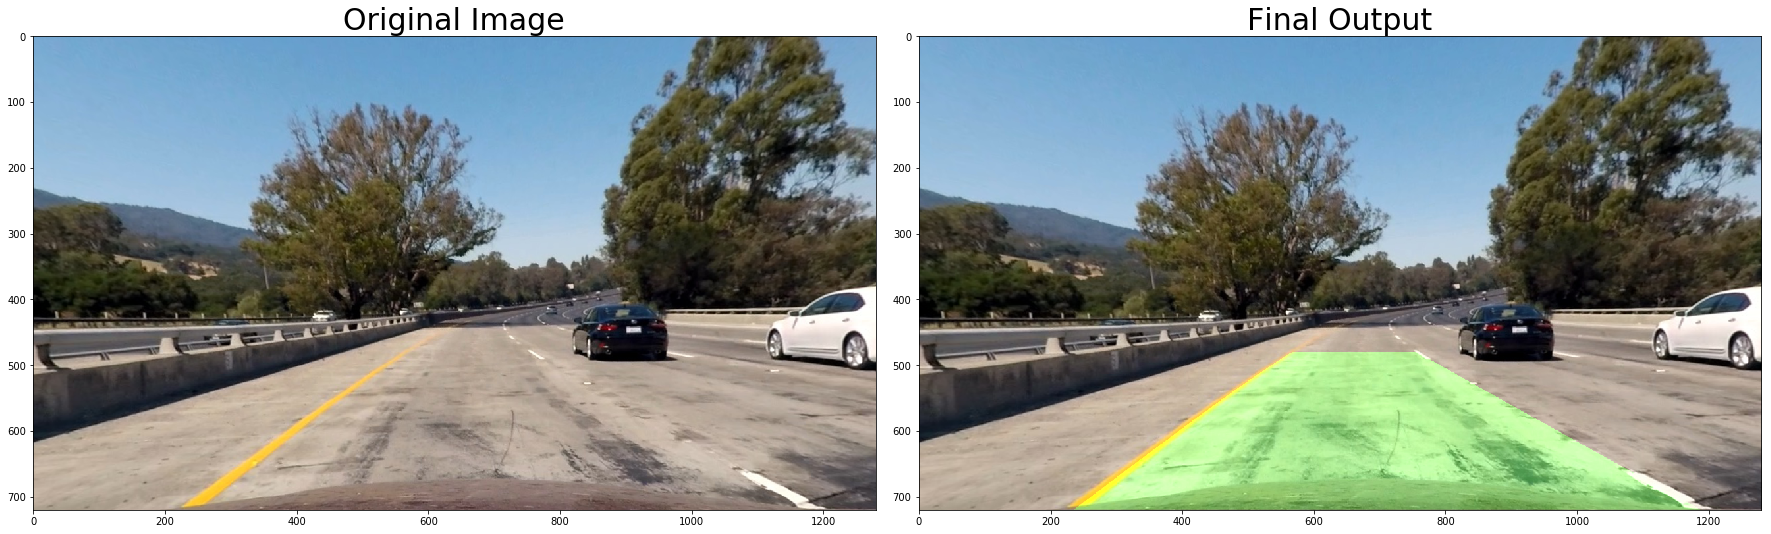

In [20]:
road_with_lanes_path = 'test_images/test1.jpg'
roadds = cv2.imread(road_with_lanes_path)
detected = lane_detection_pipeline(roadds)

In [ ]:
# This cell is only used to plot the windows and histogram for the report.

# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.title("Pixel Position of the road.jpg binary image")
plt.xlabel("Pixel position")
plt.ylabel("Pixel count")

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

plt.figure(figsize=(4, 6))
plt.subplot(2,2,1)
plt.imshow(warped, cmap='gray')
plt.title('Binary Warped', fontsize = 20)

plt.subplot(2,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth = 20)
plt.plot(right_fitx, ploty, color='yellow', linewidth = 20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected', fontsize = 20)

plt.subplot(2,2,3)
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Shaded', fontsize = 20)

plt.subplots_adjust(left=0., right=3., top=1.3, bottom=0.)


__The next cell is used to convert the video into its frames used for debugging

In [ ]:
import cv2
print(cv2.__version__)
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  print ('Read a new frame: ', success)
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  count += 1

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video_path = 'Final_6.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(lane_detection_pipeline) #put pipeline here
%time yellow_clip.write_videofile(output_video_path, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))